# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

from openpharmacophore.pharmacophore.chem_feats import feature_indices, smarts_ligand
from openpharmacophore import PharmacophoricPoint
from pprint import pprint

import itertools

## Load  and visualize ligands

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

,Smiles,PDBID,LigID
0,[H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...,1C4V,IH2
1,CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...,1TOM,MIN
2,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D6W,00R
3,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D91,00P
4,[H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...,1DWD,MID
5,[H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...,1D4P,BPP


In [3]:
ligands = []
for smi in lig_df["Smiles"]:
    mol = Chem.MolFromSmiles(smi)
    assert mol is not None
    ligands.append(mol)

supp = Chem.SDMolSupplier("0ZI.sdf")
mol = next(supp)
mol.RemoveAllConformers()
ligands.append(mol)

print(f"Num ligands: {len(ligands)}")

Num ligands: 7


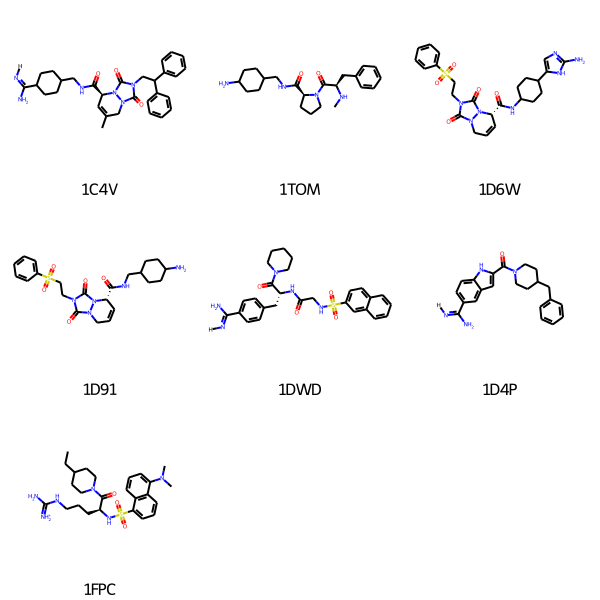

In [4]:
legends = [l for l in lig_df["PDBID"]] + ["1FPC"]
Draw.MolsToGridImage(ligands, legends=legends)

## Find chemical features in ligands

In [5]:
features = {}

for ii in range(len(ligands)):
    features[legends[ii]] = {}
    for feat_type, smarts in smarts_ligand.items():
        feat_ind = feature_indices(smarts, ligands[ii])
        if len(feat_ind) > 0:
            features[legends[ii]][feat_type] = feat_ind


In [6]:
pprint(features)

{'1C4V': {'aromatic ring': [(17, 18, 19, 21, 22),
                            (26, 27, 28, 29, 30, 31),
                            (32, 33, 34, 35, 36, 37)],
          'hb acceptor': [(12,), (20,), (23,)],
          'hb donor': [(1,), (10,), (39,)],
          'hydrophobicity': [(3, 4, 5, 6, 7, 8), (38,)],
          'positive charge': [(2, 1, 39)]},
 '1D4P': {'aromatic ring': [(6, 7, 9, 10, 11),
                            (3, 4, 5, 6, 7, 8),
                            (21, 22, 23, 24, 25, 26)],
          'hb acceptor': [(1,), (13,)],
          'hb donor': [(1,), (11,), (27,)],
          'positive charge': [(2, 1, 27)]},
 '1D6W': {'aromatic ring': [(11, 12, 14, 19, 20),
                            (31, 32, 33, 34, 35),
                            (0, 1, 2, 3, 4, 5)],
          'hb acceptor': [(33,), (7,), (8,), (13,), (21,), (23,)],
          'hb donor': [(24,), (35,), (36,)],
          'hydrophobicity': [(25, 26, 27, 28, 29, 30), (15, 16, 17)]},
 '1D91': {'aromatic ring': [(11, 12, 1

Count features in each ligand

In [7]:
feat_count = {}

for lig_id, feats in features.items():
    feat_count[lig_id] = {}
    for feat_type, feat_ind in feats.items():
        feat_count[lig_id][feat_type] = len(feat_ind)
        
pprint(feat_count)

{'1C4V': {'aromatic ring': 3,
          'hb acceptor': 3,
          'hb donor': 3,
          'hydrophobicity': 2,
          'positive charge': 1},
 '1D4P': {'aromatic ring': 3,
          'hb acceptor': 2,
          'hb donor': 3,
          'positive charge': 1},
 '1D6W': {'aromatic ring': 3,
          'hb acceptor': 6,
          'hb donor': 3,
          'hydrophobicity': 2},
 '1D91': {'aromatic ring': 2,
          'hb acceptor': 6,
          'hb donor': 2,
          'hydrophobicity': 2},
 '1DWD': {'aromatic ring': 3,
          'hb acceptor': 5,
          'hb donor': 4,
          'hydrophobicity': 2,
          'positive charge': 1},
 '1FPC': {'aromatic ring': 2,
          'hb acceptor': 3,
          'hb donor': 4,
          'hydrophobicity': 4,
          'positive charge': 2},
 '1TOM': {'aromatic ring': 1,
          'hb acceptor': 4,
          'hb donor': 3,
          'hydrophobicity': 3}}


## Finding variants of the ligands

We find the variant of each ligand. The variant is a string that represents the chemical features of each ligand in lexicographical
order

In [8]:
variants = {}

for lig_id in legends:
    var = ""
    for feat_type, count in feat_count[lig_id].items():
        char = PharmacophoricPoint.feature_to_char[feat_type]
        var += char * count

    var = "".join(sorted(var, key=str.lower))
    variants[lig_id] = var

pprint(variants)

{'1C4V': 'AAADDDHHPRRR',
 '1D4P': 'AADDDPRRR',
 '1D6W': 'AAAAAADDDHHRRR',
 '1D91': 'AAAAAADDHHRR',
 '1DWD': 'AAAAADDDDHHPRRR',
 '1FPC': 'AAADDDDHHHHPPRR',
 '1TOM': 'AAAADDDHHHR'}


In [25]:
len(list(itertools.combinations(variants["1DWD"], 5)))

3003